In [1]:
import pandas as pd
import numpy as np

In [2]:
cols = ['customer', 'accepted', 'reward', 'mailer', 'income', 'accounts', 'overdraft_protection', 'credit_rating', 'cards', 'homes', 'household', 'own_home', 'bal_q1', 'bal_q2', 'bal_q3', 'bal_q4', 'bal_avg']

data = pd.read_csv('data/creditcardmarketing.csv', names = cols)

data = data.drop('customer', axis = 1)
data

,accepted,reward,mailer,income,accounts,overdraft_protection,credit_rating,cards,homes,household,own_home,bal_q1,bal_q2,bal_q3,bal_q4,bal_avg
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136.0,65.0,71.0,398.0
17996,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984.0,940.0,943.0,535.0
17997,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918.0,767.0,1170.0,1494.0
17998,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626.0,983.0,865.0,1615.0


In [3]:
data.isna().sum()

accepted                 0
reward                   0
mailer                   0
income                   0
accounts                 0
overdraft_protection     0
credit_rating            0
cards                    0
homes                    0
household                0
own_home                 0
bal_q1                  24
bal_q2                  24
bal_q3                  24
bal_q4                  24
bal_avg                 24
dtype: int64

In [4]:
# removing small bins in 'household' and NA in balances 

data = data[data['bal_q1'].isna() == False]
data = data[data['household'] < 8]
data = data.reset_index(drop=True)
# HH = 8 
# HH = 9
# NA in balance

In [5]:
data.shape

(17974, 16)

In [6]:
# incoding the classes

data['accepted'] = np.where(data['accepted'].isin(['Yes']), 1, 0)
data['accepted'].value_counts()

0    16954
1     1020
Name: accepted, dtype: int64

In [7]:
## some charts with share of Yes vs media and reward program

In [8]:

high = data[(data['mailer']=='Postcard')&(data['reward']=='Air Miles')]

low  = data[~((data['mailer']=='Postcard')&(data['reward']=='Air Miles'))&(data['accepted']==1)]

data1 = pd.concat([high,low], axis = 0)



In [9]:
obj_cols = ['income', 'accounts', 'credit_rating', 'cards', 'homes', 'own_home', 'household']
num_cols = ['bal_avg']
 
# 'reward', 'mailer', - dropped as not related to customers, not an independent variable
# 'bal_q1', 'bal_q2', 'bal_q3', 'bal_q4', - same variance if grouped by acceptance


data_cat = data1[obj_cols]
data_num = data1[num_cols]
data_num = data_num.reset_index(drop=True)

In [10]:
# encoding categoricals

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first') # The option drop='first' drops one of the possible values.
encoder.fit(data_cat)
data_cat_encoded = encoder.transform(data_cat).toarray() # "np.sparse_array"!!
cols = encoder.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=cols)


### Balanced random forest

In [11]:
X_full = pd.concat([data_cat_df,data_num], axis = 1)
y_full = data1['accepted']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.20)

from sklearn.preprocessing import StandardScaler

transformer = StandardScaler()
transformer.fit(X_train) 
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)


In [12]:
# random forest but balanced for class imbalance

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

clf = BalancedRandomForestClassifier(criterion = 'gini', min_samples_split =6, min_samples_leaf=3, class_weight = {0:0.2,1:1},replacement=True)
clf.fit(X_train, y_train)

print("The accuracy for the Random Forest in the TRAIN  set is {:.2f}".format(clf.score(X_train, y_train)))

y_train_pred = clf.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))

y_test_pred = clf.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))


results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

# it gives low accuracy, however it correctly identifies all class 1 entries('accepted') 

The accuracy for the Random Forest in the TRAIN  set is 0.40


1    2651
0     385
dtype: int64

0    2221
1     815
Name: accepted, dtype: int64

array([[ 385, 1836],
       [   0,  815]])

The accuracy for the Random Forest in the TEST  set is 0.38


1    669
0     90
dtype: int64

0    554
1    205
Name: accepted, dtype: int64

array([[ 87, 467],
       [  3, 202]])

The results of cross-validation (full dataset): 0.38972332015810274


In [13]:
data_filtered = data1[(data1['credit_rating'].isin(['High','Medium']))&
                     (data1['household']>3)&
                     (data1['cards']<3)&
                     (data1['own_home']=='Yes')]

data_cat_f = data_filtered[obj_cols]
data_num_f = data_filtered[num_cols].reset_index(drop=True)

data_cat_encoded_f = encoder.transform(data_cat_f).toarray() 
cols = encoder.get_feature_names_out(input_features=data_cat_f.columns)
data_cat_f_df = pd.DataFrame(data_cat_encoded_f, columns=cols)

X_full_f = pd.concat([data_cat_f_df,data_num_f], axis = 1)
y_full_f = data_filtered['accepted']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full_f, y_full_f, test_size=0.20,random_state=42)

transformer = StandardScaler()
transformer.fit(X_train) 
X_train_f = transformer.transform(X_train_f)
X_test_f  = transformer.transform(X_test_f)


print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test_f, y_test_f)))
y_test_pred_f = clf.predict(X_test_f)
print('Predicted outcomes')
display(pd.DataFrame(y_test_pred_f).value_counts())
print('Actual outcomes')
display(y_test_f.value_counts())
display(confusion_matrix(y_test_f, y_test_pred_f))


The accuracy for the Random Forest in the TEST  set is 0.39
Predicted outcomes


/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1    80
0    37
dtype: int64

Actual outcomes


0    98
1    19
Name: accepted, dtype: int64

array([[32, 66],
       [ 5, 14]])

### Neural Net

In [14]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

early_stopping = EarlyStopping(patience=5) 

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model_c1 = keras.Sequential()

model_c1.add(Dense(units = 16,input_dim = X_train.shape[1],activation='relu')) 

model_c1.add(Dense(units = 16, activation='relu')) 

model_c1.add(Dense(units = 8, activation='relu'))

model_c1.add(Dense(units = 8, activation='relu'))

model_c1.add(Dense(units = 1, activation='sigmoid')) # output

model_c1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
              )

model_c1.summary()

checkpoint_path = 'models/cls-nn1.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________________


2022-07-01 12:51:59.862140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_train, y_train)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_tl), y = y_tl)
class_weights_dict = dict(enumerate(class_weights))


from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto',k_neighbors=5)
X_sm, y_sm = smote.fit_resample(X_tl, y_tl)


In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_tl, y_tl)

In [17]:
class_weights_dict_man = {0: 1, 1: 2}
class_weights_dict

{0: 0.7141355754072517, 1: 1.667484662576687}

In [18]:
history_c1 = model_c1.fit(
    X_sm, 
    y_sm, 
    epochs=50, 
    validation_split=0.20, 
    batch_size=50, 
    verbose=1,
    callbacks=[early_stopping,checkpoint],
    class_weight = class_weights_dict_man,
    #class_weight = class_weights_dict
    
)

Epoch 1/50
59/61 [============================>.] - ETA: 0s - loss: 0.9552 - accuracy: 0.4519
Epoch 1: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 1s 8ms/step - loss: 0.9540 - accuracy: 0.4507 - val_loss: 0.6543 - val_accuracy: 0.8570
Epoch 2/50
58/61 [===========================>..] - ETA: 0s - loss: 0.9378 - accuracy: 0.4997
Epoch 2: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 4ms/step - loss: 0.9365 - accuracy: 0.4984 - val_loss: 0.6116 - val_accuracy: 0.8675
Epoch 3/50
53/61 [=========================>....] - ETA: 0s - loss: 0.9140 - accuracy: 0.5392
Epoch 3: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 5ms/step - loss: 0.9101 - accuracy: 0.5489 - val_loss: 0.5670 - val_accuracy: 0.7559
Epoch 4/50
53/61 [=========================>....] - ETA: 0s - loss: 0.8829 - accuracy: 0.6283
Epoch 4: saving model to models/cls-nn1.hdf5
61/61 [==============================] - 0s 5ms/step - lo

In [19]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

y_pred_train = model_c1.predict(X_train).round(0) ## rounded to 1
y_pred_test  = model_c1.predict(X_test).round(0) ## rounded to 1

y_train1 = np.array(y_train).reshape(-1,1)
y_test1  = np.array(y_test).reshape(-1,1)

results = model_performance_class(y_train1, y_pred_train, y_test1, y_pred_test)
results

display(confusion_matrix(y_test1, y_pred_test))



24/24 [==============================] - 0s 3ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.30
              precision    recall  f1-score   support

           0       0.88      0.60      0.72      2221
           1       0.42      0.78      0.54       815

    accuracy                           0.65      3036
   macro avg       0.65      0.69      0.63      3036
weighted avg       0.76      0.65      0.67      3036

Results obtained for the TEST SET
The Cohen's Kappa is: 0.25
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       554
           1       0.39      0.79      0.52       205

    accuracy                           0.61       759
   macro avg       0.63      0.67      0.60       759
weighted avg       0.74      0.61      0.63       759



array([[304, 250],
       [ 44, 161]])

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(n_estimators = 500, max_depth=6, min_samples_split =2, min_samples_leaf=1)
GBC.fit(X_train, y_train)


print("The accuracy for the GBC in the TRAIN  set is {:.2f}".format(GBC.score(X_train, y_train)))

y_train_pred = GBC.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the GBC in the TEST  set is {:.2f}".format(GBC.score(X_test, y_test)))

y_test_pred = GBC.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))


results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

The accuracy for the GBC in the TRAIN  set is 1.00


0    2225
1     811
dtype: int64

0    2221
1     815
Name: accepted, dtype: int64

array([[2220,    1],
       [   5,  810]])

The accuracy for the GBC in the TEST  set is 0.72


0    606
1    153
dtype: int64

0    554
1    205
Name: accepted, dtype: int64

array([[472,  82],
       [134,  71]])

The results of cross-validation (full dataset): 0.3918313570487484


In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("The accuracy for the GNB in the TRAIN  set is {:.2f}".format(gnb.score(X_train, y_train)))

y_train_pred = gnb.predict(X_train)
display(pd.DataFrame(y_train_pred).value_counts())
display(y_train.value_counts())
display(confusion_matrix(y_train, y_train_pred))

print("The accuracy for the GNB in the TEST  set is {:.2f}".format(gnb.score(X_test, y_test)))

y_test_pred = gnb.predict(X_test)
display(pd.DataFrame(y_test_pred).value_counts())
display(y_test.value_counts())
display(confusion_matrix(y_test, y_test_pred))

results = cross_validate(clf,X_full, y_full, cv = 5) 
print('The results of cross-validation (full dataset):',(results['test_score']).mean())

The accuracy for the GNB in the TRAIN  set is 0.72


0    2501
1     535
dtype: int64

0    2221
1     815
Name: accepted, dtype: int64

array([[1940,  281],
       [ 561,  254]])

The accuracy for the GNB in the TEST  set is 0.74


0    613
1    146
dtype: int64

0    554
1    205
Name: accepted, dtype: int64

array([[483,  71],
       [130,  75]])

The results of cross-validation (full dataset): 0.39156785243741765


### TSNE

In [22]:
X_cool = X_full#.drop(['reward_Cash Back', 'reward_Points','mailer_Postcard'],axis=1)
X_cool = pd.concat([X_cool,y_full.reset_index(drop=True)],axis=1)
cols = X_cool.columns
from sklearn.preprocessing import MinMaxScaler

transformer = StandardScaler()
transformer.fit(X_cool) 
X_cool = transformer.transform(X_cool)


In [23]:
from sklearn.manifold import TSNE
X_embedded = TSNE (n_components = 2, learning_rate = 'auto', init = 'random').fit_transform(X_cool)
#X_embedded.shape

In [24]:
xx = [row[0] for row in X_embedded]
yy = [row[1] for row in X_embedded]

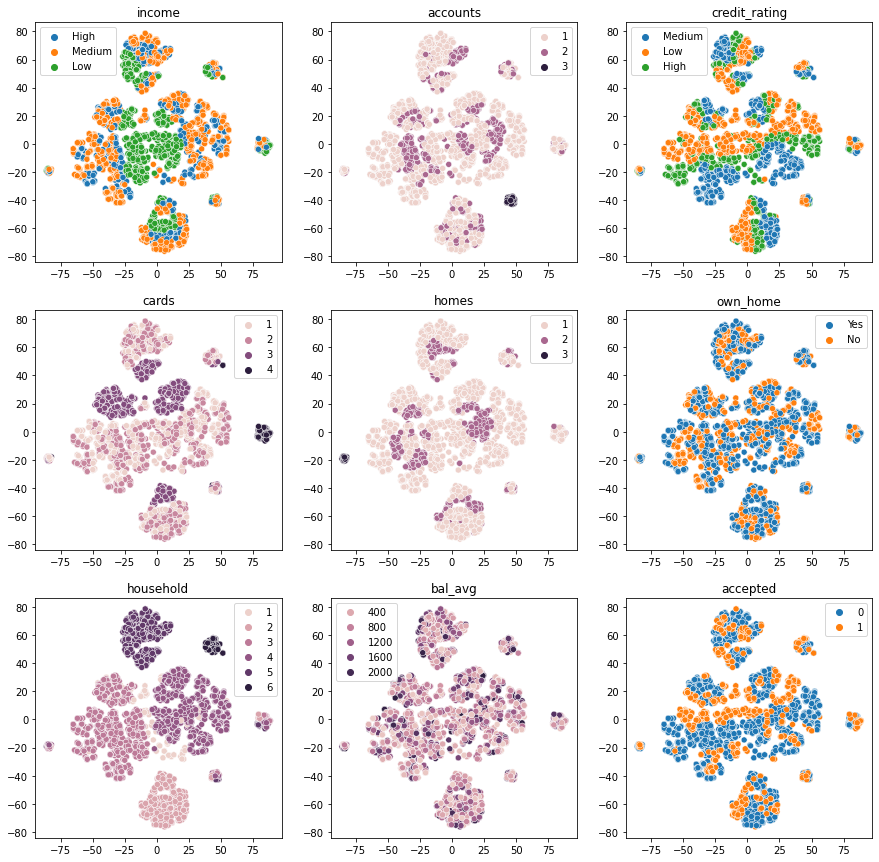

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns 
import math
%matplotlib inline

cols = obj_cols+num_cols
cols.extend(['accepted'])



fig, ax1 = plt.subplots(math.ceil(len(cols)/3),3, figsize=(15,15)) 
for n,col in enumerate(cols):
    sns.scatterplot( x=xx, y = yy, hue=[i for i in data1[col]], ax=ax1[math.floor(n/3),n%3]).set(title=col)
    
plt.savefig('data/smte.png')

plt.show()

### Checking for dependencies

In [26]:
# Split of the ballances first
def bal_split(a):
    if   a <  700:  return 'a'
    elif a <= 1400: return 'b'
    elif a <= 1900: return 'c'
    else:           return 'd'


data['bal_avg_bin'] = data['bal_avg'].apply(bal_split)
data['bal_q1_bin'] = data['bal_q1'].apply(bal_split)
data['bal_q2_bin'] = data['bal_q2'].apply(bal_split)
data['bal_q3_bin'] = data['bal_q3'].apply(bal_split)
data['bal_q4_bin'] = data['bal_q4'].apply(bal_split)

data.columns

Index(['accepted', 'reward', 'mailer', 'income', 'accounts',
       'overdraft_protection', 'credit_rating', 'cards', 'homes', 'household',
       'own_home', 'bal_q1', 'bal_q2', 'bal_q3', 'bal_q4', 'bal_avg',
       'bal_avg_bin', 'bal_q1_bin', 'bal_q2_bin', 'bal_q3_bin', 'bal_q4_bin'],
      dtype='object')

In [27]:
# Checking if independent variables are independent of each other

import scipy.stats as st

cols_chi = obj_cols + ['bal_q1_bin', 'bal_q2_bin', 'bal_q3_bin', 'bal_q4_bin', 'bal_avg_bin']

res = [(a, b) for idx, a in enumerate(cols_chi) for b in cols_chi[idx + 1:]]

for i in res:
    data_crosstab = pd.crosstab(data[i[0]], data[i[1]], margins = False, normalize=False)
    print(st.chi2_contingency(data_crosstab)[1].round(4), i[0], i[1])

# ok, the inputs are indepenent

0.0701 income accounts
0.5748 income credit_rating
0.9612 income cards
0.9098 income homes
0.3565 income own_home
0.3829 income household
0.887 income bal_q1_bin
0.1714 income bal_q2_bin
0.9482 income bal_q3_bin
0.3225 income bal_q4_bin
0.2832 income bal_avg_bin
0.3789 accounts credit_rating
0.7998 accounts cards
0.8548 accounts homes
0.4233 accounts own_home
0.1423 accounts household
0.2672 accounts bal_q1_bin
0.6687 accounts bal_q2_bin
0.0022 accounts bal_q3_bin
0.7717 accounts bal_q4_bin
0.2666 accounts bal_avg_bin
0.7699 credit_rating cards
0.4136 credit_rating homes
0.6032 credit_rating own_home
0.2502 credit_rating household
0.134 credit_rating bal_q1_bin
0.0017 credit_rating bal_q2_bin
0.0053 credit_rating bal_q3_bin
0.7776 credit_rating bal_q4_bin
0.0056 credit_rating bal_avg_bin
0.8434 cards homes
0.8635 cards own_home
0.8383 cards household
0.5894 cards bal_q1_bin
0.4137 cards bal_q2_bin
0.6768 cards bal_q3_bin
0.9879 cards bal_q4_bin
0.0129 cards bal_avg_bin
0.5535 homes own

In [28]:
# Checking if independent variables are independent of acceptance


for i in cols_chi:
    data_crosstab = pd.crosstab(data['accepted'], data[i], margins = False, normalize=False)
    print(st.chi2_contingency(data_crosstab)[1].round(4), 'accepted', i)

# we can define target columns with p-val 10%

0.0 accepted income
0.4423 accepted accounts
0.0 accepted credit_rating
0.731 accepted cards
0.8777 accepted homes
0.9907 accepted own_home
0.0912 accepted household
0.6392 accepted bal_q1_bin
0.1299 accepted bal_q2_bin
0.9511 accepted bal_q3_bin
0.1558 accepted bal_q4_bin
0.7625 accepted bal_avg_bin


In [29]:
# did media and reward affected the acceptance? yes

for i in ['mailer','reward']:
    data_crosstab = pd.crosstab(data['accepted'], data[i], margins = False, normalize=False)
    print(st.chi2_contingency(data_crosstab)[1].round(4), 'accepted', i)
    
# was media distributed randomly accross the groups? yes

for i in cols_chi:
    data_crosstab = pd.crosstab(data['mailer'], data[i], margins = False, normalize=False)
    print(st.chi2_contingency(data_crosstab)[1].round(4), 'mailer', i)

# was reward distributed randomly across the groups? yes
    
for i in cols_chi:
    data_crosstab = pd.crosstab(data['reward'], data[i], margins = False, normalize=False)
    print(st.chi2_contingency(data_crosstab)[1].round(4), 'reward', i)


0.0 accepted mailer
0.0 accepted reward
0.5964 mailer income
0.9518 mailer accounts
0.7274 mailer credit_rating
0.4218 mailer cards
0.5414 mailer homes
0.5875 mailer own_home
0.4458 mailer household
0.0933 mailer bal_q1_bin
0.7779 mailer bal_q2_bin
0.8595 mailer bal_q3_bin
0.8437 mailer bal_q4_bin
0.0051 mailer bal_avg_bin
0.6526 reward income
0.0575 reward accounts
0.6592 reward credit_rating
0.4798 reward cards
0.8136 reward homes
0.3849 reward own_home
0.8808 reward household
0.916 reward bal_q1_bin
0.8718 reward bal_q2_bin
0.0521 reward bal_q3_bin
0.8644 reward bal_q4_bin
0.576 reward bal_avg_bin


In [30]:
pd.crosstab(data['reward'], data['bal_q3_bin'], margins = False, normalize=False)

bal_q3_bin,a,b,c,d
reward,,,,
Air Miles,1613,3240,1159,34
Cash Back,1587,3140,1249,19
Points,1624,3083,1206,20


In [31]:
# the bins and the probabilities (relative shares of accepted offers)

final_cols = ['income','credit_rating','household','accepted']
test_data = data[(data['mailer']=='Postcard')&(data['reward']=='Air Miles')][final_cols] # the best media and reward

a = test_data.groupby(['income','credit_rating','household'])[['accepted']].sum() / test_data.groupby(['income','credit_rating','household']).count()

shares = test_data.groupby(['income','credit_rating','household']).agg({'accepted':[sum,pd.Series.count]})
shares['accepted']['share'] = shares['accepted']['sum']/shares['accepted']['count']

shares.columns = shares.columns.get_level_values(1)
shares['share'] = shares['sum']/shares['count']
shares = shares.reset_index()
shares.head(5)

,income,credit_rating,household,sum,count,share
0,High,High,1,0,16,0.000000
1,High,High,2,1,33,0.030303
2,High,High,3,2,98,0.020408
3,High,High,4,3,77,0.038961
4,High,High,5,3,46,0.065217


In [32]:
shares['count'].sum() # total entries counted (only best media and reward)

3100

In [33]:
shares['sum'].sum() # total accepted (10% vs 6% across the whole dataset)

325

In [34]:
# probabilites to all entries of the original dataset

def selector(a,b,c):
    return shares[(shares['income']==a)&(shares['credit_rating']==b)&(shares['household']==c)]['share'].values[0]

data['share'] = data.apply(lambda x: selector(a = x['income'], b = x['credit_rating'], c = x['household']), axis=1)

In [35]:
# extrapolation of the best compaign for the whole dataset

potent = data.groupby(['income','credit_rating','household']).agg({'accepted':[sum,pd.Series.count],'share':np.mean})
potent.columns = potent.columns.get_level_values(1)

(potent['count']*potent['mean']).sum()

1860.669272585296

In [36]:
potent['sum'].sum() # original dataset - accepted

1020